In [1]:
from scipy.sparse import coo_matrix
import pandas
from scipy.sparse import csr_matrix
import numpy
from math import sqrt
from sklearn.metrics import mean_squared_error
import sys
import matplotlib.pyplot as plt
%matplotlib inline

### Loading train data, train labels, validation data and validation labels

In [2]:
train_data = pandas.read_csv("./newDataset/trainData.txt", delimiter = ' ', header=None)
train_labels = pandas.read_csv("./newDataset/trainLabels.txt", header=None)

In [3]:
val_data = pandas.read_csv("./newDataset/valData.txt", delimiter = ' ', header=None)
val_labels = pandas.read_csv("./newDataset/valLabels.txt", header=None)

In [4]:
columns = []
rows = []
columns_val = []
rows_val = []

#### Converting the training and validation data into matrix market format.

In [5]:
for key, value in val_data.iterrows():
    columns_val.append(value[0] - 1)
    rows_val.append(value[1] - 1)
values_val = val_data[2]
y_val = val_labels[0]
coo_val = coo_matrix((values_val, (rows_val, columns_val)))
csr_val = coo_val.tocsr()

In [6]:
csr_y_val = csr_matrix(y_val)
csr_y_val = csr_y_val.transpose()

In [10]:
for key, value in train_data.iterrows():
    columns.append(value[0] - 1)
    rows.append(value[1] - 1)
values = train_data[2]
y = train_labels[0]
coo = coo_matrix((values, (rows, columns)))
csr = coo.tocsr()
csr_y = csr_matrix(y)
csr_y = csr_y.transpose()

In [13]:
d = csr.shape[0]
N = csr.shape[1]

### Calculating Lambda Max

In [16]:
sum_y = csr_y.sum() / N
to_multiply = csr_y - csr_matrix(sum_y * numpy.ones(shape=(N, 1)))
multiplied_with_x = csr * to_multiply
lambda_max = 2 * numpy.linalg.norm(multiplied_with_x.toarray(), numpy.inf)

In [19]:
def coordinate_descent_scipy(x, w, bias_list, lambda_max, iterate):
    lambda_1 = lambda_max * 2
    d = x.shape[0]
    for iteration in range(0, iterate):
        ak = [1] * x.shape[0]
        lambda_1 = lambda_1 / 2
        for k in range(0, d):
            temp = x.getrow(k)
            ak[k] = 2 * temp.multiply(temp).sum()
        count = 0
        if iteration != 0:
            bias_list = bias.copy()
            bias_list = csr_matrix(bias_list * numpy.ones(shape = (N, 1)))
        old_objective_function = 0
        while True:
            ck = [0] * d
            #Calculate r
            r = csr_y - ((x.transpose() * w) + bias_list)
            
            # Calculate new bias
            new_bias = (r.sum() / float(N)) + bias_list.toarray()[0][0]
            r = r - csr_matrix((r.sum() / float(N)) * numpy.ones(shape=(N, 1)))
            bias = new_bias
            
            for k in range(0, d):
                temp = 0
                current_row = x.getrow(k)
                columns_indices = current_row.nonzero()[1]
                for i in columns_indices:
                    temp += current_row[0, i] * (r[i, 0] + (w[k, 0] * current_row[0, i]))
                temp = float(temp)
                ck[k] = 2 * temp
                
                if ck[k] < -1 * lambda_1:
                    new_wk = float((ck[k] + lambda_1)) / ak[k]
                elif ck[k] > lambda_1:
                    new_wk = float((ck[k] - lambda_1)) / ak[k]
                else:
                    new_wk = 0.0
                
                # update r
                r += (w[k].toarray()[0][0] - new_wk) * current_row.transpose()
                w[k] = new_wk
            # calculate the objective function    
            objective_function = (r.transpose() * r).toarray()[0][0] + lambda_1 * abs(w).sum()
            print("objective_function: ", objective_function)
            
            # check if the objective function value has decreased from before, if yes, then break
            if abs(old_objective_function - objective_function) < 1:
                break
            old_objective_function = objective_function
    return w, bias            

In [53]:
lambda_max

1271.8696510000054

In [54]:
bias = 10
bias = bias * csr_matrix(numpy.ones(shape=(N, 1)))
weights = 1
#print(numpy.shape(w))
weights = weights * csr_matrix(numpy.ones(shape=(d, 1)))
weights_array = []
#lambda_max = lambda_max / 2
validation_error_array = []
train_error_array = []
bias_array = []
lambda_array = []
non_zeroes_array = []
old_validation_error = sys.maxsize
count = 0
while True:
    count += 1
    print("Iteration number: ", count)
    weights, bias = coordinate_descent_scipy(csr, weights, bias, lambda_max, 1)
    
    predict_y = (csr.transpose() * weights) + (bias * csr_matrix(numpy.ones(shape=(N, 1))))
    train_error = sqrt(mean_squared_error(csr_y.toarray(), predict_y.toarray()))
    train_error_array.append(train_error)
    
    predict_y_val = (csr_val.transpose() * weights) + (bias * csr_matrix(numpy.ones(shape=(N, 1))))
    validation_error = sqrt(mean_squared_error(csr_y_val.toarray(), predict_y_val.toarray()))
    validation_error_array.append(validation_error)
    
    weights_array.append(weights)
    bias_array.append(bias)
    bias = bias * csr_matrix(numpy.ones(shape=(N, 1)))
    lambda_array.append(lambda_max)
    non_zeroes_array.append(weights.count_nonzero())
    
    print("lambda: ", lambda_max)
    print("validation error: ", validation_error_array)
    print("train error: ", train_error_array)
    
    if old_validation_error - validation_error <  0:
        break
    
    old_validation_error = validation_error
    lambda_max = lambda_max / 2
    

Iteration number:  1
objective_function:  230851.28474350512
objective_function:  169608.56521983468
objective_function:  127424.11821958868
objective_function:  116030.55659890533
objective_function:  115339.97589998547
objective_function:  115339.97589998547
lambda:  1271.8696510000054
validation error:  [3.3895861945081145]
train error:  [3.396173963447691]
Iteration number:  2
objective_function:  113464.97051962464
objective_function:  113351.72481509436
objective_function:  113268.05422605101
objective_function:  113230.35547283216
objective_function:  113218.39606288074
objective_function:  113214.75937298461
objective_function:  113213.59848669515
objective_function:  113213.21645900796
lambda:  635.9348255000027
validation error:  [3.3895861945081145, 3.2411015096815357]
train error:  [3.396173963447691, 3.238243342269178]
Iteration number:  3
objective_function:  104742.93004452213
objective_function:  104553.47250832178
objective_function:  104544.92720643431
objective_funct

objective_function:  39819.943340057216
objective_function:  39810.9664051092
objective_function:  39802.23677526966
objective_function:  39793.77180955692
objective_function:  39785.59983597766
objective_function:  39777.74473235086
objective_function:  39770.224839187824
objective_function:  39763.056095148124
objective_function:  39756.24010599839
objective_function:  39749.776588102235
objective_function:  39743.66657402892
objective_function:  39737.89459713619
objective_function:  39732.45951231767
objective_function:  39727.357329018414
objective_function:  39722.5805778748
objective_function:  39718.11708562424
objective_function:  39713.95401494578
objective_function:  39710.08063427804
objective_function:  39706.480874206085
objective_function:  39703.136258861625
objective_function:  39700.02896313743
objective_function:  39697.139971456076
objective_function:  39694.45042982289
objective_function:  39691.94288685164
objective_function:  39689.59948528494
objective_function:

### Read the test data

In [55]:
test_data = pandas.read_csv("./newDataset/testData.txt", delimiter = ' ', header=None)

In [56]:
columns_test = []
rows_test = []
for key, value in test_data.iterrows():
    columns_test.append(value[0] - 1)
    rows_test.append(value[1] - 1)
values_test = test_data[2]

### Convert the test data into matrix maket format

In [57]:
coo_test = coo_matrix((values_test, (rows_test, columns_test)))
csr_test = coo_test.tocsr()

### Take the weights and bias corresponding to the optimum lambda for building the model

In [90]:
w = weights_array[-3]
bias = bias_array[-3]


In [91]:
w

<3000x1 sparse matrix of type '<class 'numpy.float64'>'
	with 3000 stored elements in Compressed Sparse Row format>

In [68]:
csr_test = csr_test.transpose()

In [92]:
bias

84.0493058242642

In [86]:
new_N = csr_test.shape[1]
new_N

20534

### Predict the reviews for the test data using optimum weights and bias

In [93]:
predict_y_test = (csr_test.transpose() * w) + (bias * csr_matrix(numpy.ones(shape=(new_N, 1))))

In [94]:
result = pandas.DataFrame(predict_y_test.toarray())
result['ID'] = pandas.Series([i for i in range(1, 20535)], index = result.index)
result.columns = ['Points', 'ID']
cols_names = list(result.columns.values) #Make a list of all of the columns in the df
cols_names.pop(cols_names.index('Points')) #Remove b from list
result = result[cols_names+['Points']] 
result.head()

,ID,Points
0,1,93.156553
1,2,83.703088
2,3,91.751541
3,4,89.636119
4,5,84.003999


### Create a submission file


In [95]:
result.to_csv("predTestLabels.csv", index = None)

# RMSE after submitting the Predicted Test labels is 1.97491

In [100]:
iteration = [i for i in range(1, len(validation_error_array) + 1)]

### Plot a graph for Iteration vs Root Mean Square Error
I used iteration number instead of lambda values, the graph of lambda values vs root mean square error doesn't turn out to be good, it's not interpretable as compared for the iteration values. For each iteration, the lambda values decreases by a factor of 2

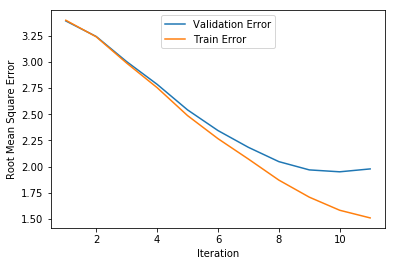

In [108]:
plt.plot(iteration, validation_error_array)
plt.plot(iteration, train_error_array)

plt.xlabel("Iteration")
plt.ylabel("Root Mean Square Error")
plt.legend(('Validation Error', 'Train Error'),
           loc='upper center')

### Plot a graph for Iteration number vs number of non zeroes

Text(0,0.5,'Number of non zeroes')

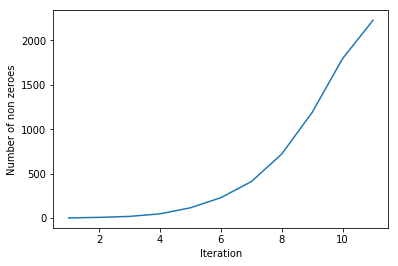

In [110]:
plt.plot(iteration, non_zeroes_array)

plt.xlabel("Iteration")
plt.ylabel("Number of non zeroes")

#### The optimum values for lambda, bias and weights are as follows:

In [111]:
best_lambda = lambda_array[-2]
best_lambda

2.4841204121093856

In [112]:
best_bias = bias_array[-2]
best_bias

83.22064704069054

In [121]:
best_weights = weights_array[-2]
best_weights

<3000x1 sparse matrix of type '<class 'numpy.float64'>'
	with 3000 stored elements in Compressed Sparse Row format>

In [122]:
best_weights.toarray()

array([[ 0.        ],
       [ 3.62416019],
       [ 5.12919378],
       ...,
       [-0.25739355],
       [ 0.84228094],
       [ 1.6294963 ]])

#### Finding the bottom and top 10 weights

In [127]:
lowest_weights = sorted(best_weights.toarray())[0:10]

In [130]:
top_weights = sorted(best_weights.toarray(), reverse = True)[0:10]

In [133]:
top_weights_index = []
lowest_weights_index = []
best_weights_array = best_weights.toarray().tolist()
for i in range(0, 10):
    top_weights_index.append(best_weights_array.index(top_weights[i]))
    lowest_weights_index.append(best_weights_array.index(lowest_weights[i]))


In [141]:
labels_text = pandas.read_csv("./newDataset/featureTypes.txt", header = None)

In [156]:
top_weights_labels = []
low_weights_labels = []

for i in range(0, 10):
    top_weights_labels.append(labels_text[0][top_weights_index[i]])
    low_weights_labels.append(labels_text[0][lowest_weights_index[i]])
    

In [157]:
top_weights_labels

['spearmint',
 'huge',
 'lifesaver',
 'big',
 'stars',
 'ageability',
 'lemony',
 'truly',
 'acidity provides',
 'nearly']

#### The top weight features are similar to each other and it shows that the spearmint contributes maximum to the review. When any of these words appear they contribute the maximum to the review hence increasing the review

In [158]:
low_weights_labels

['earns',
 'cherry berry',
 'liqueur',
 'semillon',
 'sparkler',
 'flavors enriched',
 'supported',
 'banana',
 'rest',
 'brightened']

#### The low weight features are not similar to each other, and looking at their weights it seems that they contribute very less to the review. Earns contributes the lowest to the review. These words tend to decrease the review.